In [12]:
from neuron import h
import os
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))




#First compile our modfiles.
if os.system('nrnivmodl modfiles/') == 0:
    print("Compilation Succeeded.")
else:
    print("Compilation Failed.")


Compilation Succeeded.


In [13]:
h.load_file('stdrun.hoc')

#Define simumulation parameters.
SIMRUNTIME = 1500
DELAY      = 400
INJTIME    = 500
I_INJ      = 0.2

h.tstop    = SIMRUNTIME
h.v_init   = -75



In [14]:
#Define Cell Morphology.
soma = h.Section(name = 'soma')

soma.nseg = 1
soma.L    = 25
soma.diam = 24.75

dend = []
dend.append(h.Section(name = 'dend0'))
dend.append(h.Section(name = 'dend1'))

dend[0].nseg = 8
dend[0].L    = 270 
dend[0].diam = 3

dend[1].nseg = 1
dend[1].L    = 400
dend[1].diam = 5

#Connect the sections.
dend[0].connect(soma(0))
dend[1].connect(soma(1))

#Define the biophysical parameters.
soma.Ra = dend[0].Ra = dend[1].Ra = 150
soma.cm = dend[0].cm = dend[1].cm = 2.4


In [15]:
#Insert channels into all sections.
#Insert the bursting module.
soma.insert('leakCA3')
soma.insert('natCA3')
soma.insert('kdrCA3')
for d in dend:
    d.insert('leakCA3')
    d.insert('natCA3')
    d.insert('kdrCA3')

#Insert the doublet module.
soma.insert('hdCA3')
soma.insert('nap')
soma.insert('im')
for d in dend:
    d.insert('hdCA3')
    d.insert('nap')
    d.insert('im')

In [16]:
#Set the conductance values.
'''
gnat = 0.065 
ghd  = 1.0e-5 
gkdr = 0.065  
gnap = 0.002 
gim  = 0.007
'''

soma.glbar_leakCA3 = 1.53*3e-5
soma.gbar_natCA3   = 0.065
soma.gbar_nap      = 0.002
soma.gbar_kdrCA3   = 0.065
soma.ghdbar_hdCA3  = 1.0e-5
soma.gbar_im       = 0.007

for d in dend:    
    d.glbar_leakCA3 = 1.53*3e-5
    d.gbar_natCA3   = 0.065
    d.gbar_nap      = 0.002
    d.gbar_kdrCA3   = 0.065
    d.ghdbar_hdCA3  = 1.0e-5
    d.gbar_im       = 0.007

    
#Set the reversal potentials
soma.ena = dend[0].ena = dend[1].ena = 45
soma.ek  = dend[0].ek  = dend[1].ek  = -80 
#soma.ehd = dend[0].ehd = dend[1].ehd = -45


In [17]:
#Set up the current injection.
i_inj = h.IClamp(soma(0.5))
i_inj.amp   = I_INJ
i_inj.dur   = INJTIME
i_inj.delay = DELAY

time = h.Vector()
potential = h.Vector()

#Record the membrane variables.
time.record(h._ref_t) 
potential.record(soma(0.5)._ref_v)

#Set up vectors to record currents, gating variables, and tau variables.
#[0,3] -> currents, [4,8] -> gating variables, [9, 13] -> tau
recording_vectors = []
for i in range(14):
    recording_vectors.append(h.Vector())

#Now we have to manually assign each vector to what it is recording.
recording_vectors[0].record(soma(0.5).natCA3._ref_i)
recording_vectors[1].record(soma(0.5).kdrCA3._ref_i)
recording_vectors[2].record(soma(0.5).nap._ref_i)
recording_vectors[3].record(soma(0.5).im._ref_i)

recording_vectors[4].record(soma(0.5).natCA3._ref_minf)
recording_vectors[5].record(soma(0.5).natCA3._ref_hinf)
recording_vectors[6].record(soma(0.5).kdrCA3._ref_ninf)
recording_vectors[7].record(soma(0.5).nap._ref_minf)
recording_vectors[8].record(soma(0.5).im._ref_ninf)

recording_vectors[9].record(soma(0.5).natCA3._ref_mtau)
recording_vectors[10].record(soma(0.5).natCA3._ref_htau)
recording_vectors[11].record(soma(0.5).kdrCA3._ref_taun)
recording_vectors[12].record(soma(0.5).nap._ref_mtau)
recording_vectors[13].record(soma(0.5).im._ref_taun)

#Run the experiment.
h.run()

0.0

In [18]:
#Plot membrane potential of tonic cell.
def plot_membrane():
    plt.close()
    plt.figure(figsize = (20,5))
    plt.plot(time, potential)
    plt.xlabel('Time')
    plt.ylabel('Membrane Potential')
    plt.show()

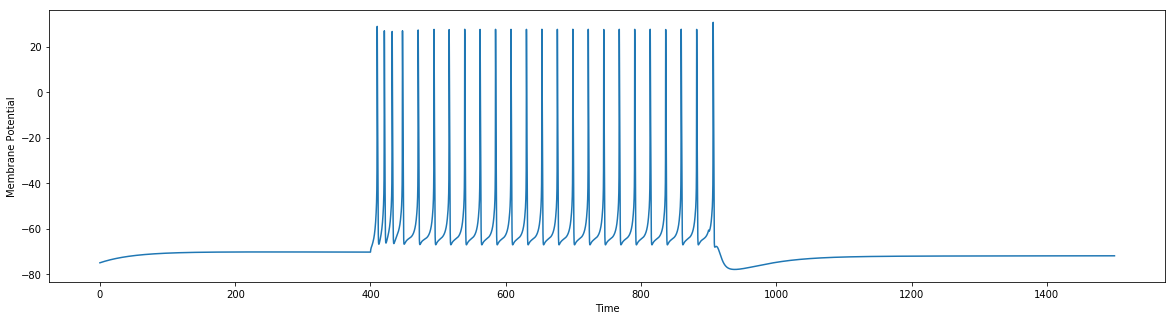

In [19]:
plot_membrane()

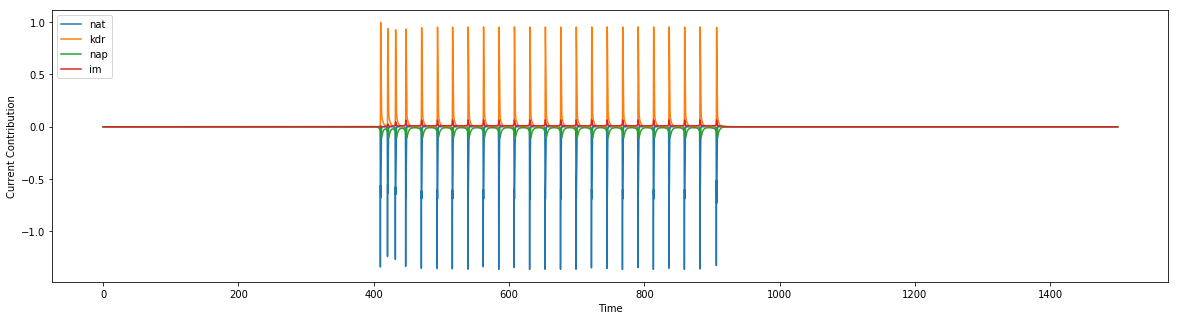

In [20]:
#Plot currents.
def plot_currents():
    plt.close()
    plt.figure(figsize = (20,5))
    
    labels = ['nat', 'kdr', 'nap', 'im']
    
    for i in range(4):
        plt.plot(time, recording_vectors[i], label = labels[i])
    
    plt.legend(loc="upper left")
    plt.xlabel('Time')
    plt.ylabel('Current Contribution')
    plt.show()
    
plot_currents()

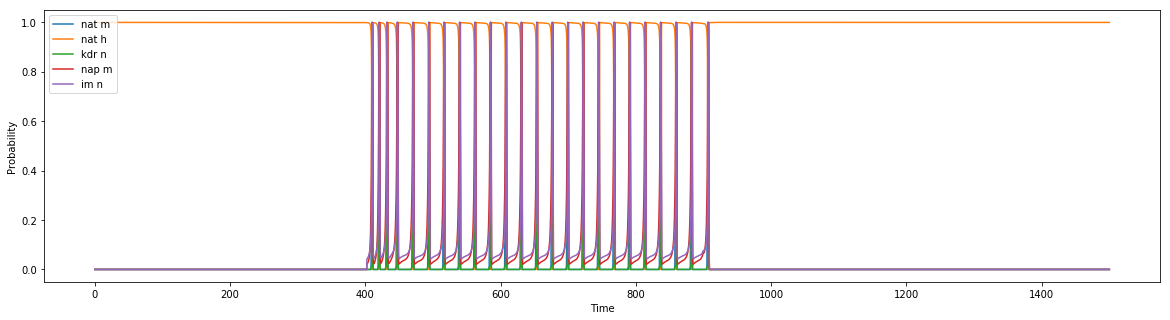

In [21]:
#Plot gating variables.
def plot_gating():
    plt.close()
    plt.figure(figsize = (20,5))
    
    labels = ['nat m', 'nat h', 'kdr n', 'nap m', 'im n']
    
    for i in range(4, 9):
        plt.plot(time, recording_vectors[i], label = labels[i - 4])
    
    plt.legend(loc="upper left")
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.show()
    
plot_gating()

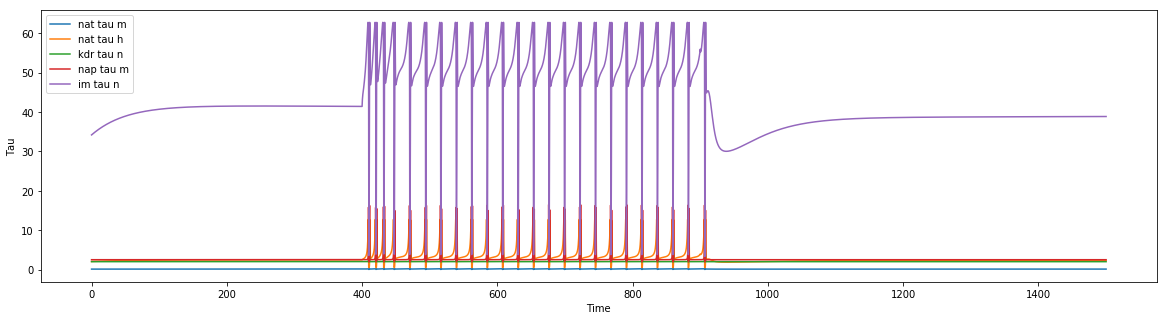

In [22]:
#Plot tau variables.
def plot_tau():
    plt.close()
    plt.figure(figsize = (20,5))
    
    labels = ['nat tau m', 'nat tau h', 'kdr tau n', 'nap tau m', 'im tau n']
    
    for i in range(9, 14):
        plt.plot(time, recording_vectors[i], label = labels[i - 9])
    
    plt.legend(loc="upper left")
    plt.xlabel('Time')
    plt.ylabel('Tau')
    plt.show()
    
plot_tau()

In [24]:
#Create the all in one interactive plot.
import ipywidgets as widgets
from ipywidgets import HBox,VBox,Label,Layout
from IPython.display import display
%matplotlib inline

default = [0.2, 1.0e-5, 0.065, 0.065, 0.002, 0.007]

def run_model(amp, ghd, gnat, gkdr, gnap, gim):
    soma.glbar_leakCA3 = 1.53*3e-5
    soma.gbar_natCA3   = gnat
    soma.gbar_nap      = gnap
    soma.gbar_kdrCA3   = gkdr
    soma.ghdbar_hdCA3  = ghd
    soma.gbar_im       = gim

    for d in dend:    
        d.glbar_leakCA3 = 1.53*3e-5
        d.gbar_natCA3   = gnat
        d.gbar_nap      = gnap
        d.gbar_kdrCA3   = gkdr
        d.ghdbar_hdCA3  = ghd
        d.gbar_im       = gim
    
    i_inj.amp = amp
    
    h.run()
    plot_membrane()
    plot_currents()
    plot_gating()
    plot_tau()
    

    
#run_model(0.2, 1.0e-5, 0.065, 0.065, 0.002, 0.007)

#Make a list of all widgets.
#Contains: amp slider, g_h slider, g_nat slider, g_kdr slider, g_nap slider, g_im slider.
sliders = []
sliders.append(widgets.FloatSlider(value = default[0], min = 0.1, max = 1.0, step = 0.1, continuous_update=False, readout_format='.1f'))
sliders.append(widgets.FloatSlider(value = default[1], min = 1.0e-5, max = 2.3e-4, step = 2.2e-6, continuous_update=False, readout_format='.1e'))
sliders.append(widgets.FloatSlider(value = default[2], min = 0.001, max = 0.36, step = 0.00359, continuous_update=False, readout_format='.1e'))
sliders.append(widgets.FloatSlider(value = default[3], min = 6.0e-4, max = 0.18, step = 0.001794, continuous_update=False, readout_format='.1e'))
sliders.append(widgets.FloatSlider(value = default[4], min = 1.0e-5, max = 0.005, step = 4.99e-5, continuous_update=False, readout_format='.1e'))
sliders.append(widgets.FloatSlider(value = default[5], min = 5.0e-6, max = 0.017, step = 1.6995e-4, continuous_update=False, readout_format='.1e'))

labels = []
labels.append(Label(r'\( I_{inject}\ (nA) \)'))
labels.append(Label(r'\( g_{h}\ (mS/cm^2) \)'))
labels.append(Label(r'\( g_{NaT}\ (mS/cm^2) \)'))
labels.append(Label(r'\( g_{Kdr}\ (mS/cm^2) \)'))
labels.append(Label(r'\( g_{NaP}\ (mS/cm^2) \)'))
labels.append(Label(r'\( g_{Km}\ (mS/cm^2) \)'))

def reset_model(*args):
    for i in range(6):
        sliders[i].value = default[i]


reset = widgets.Button(description='Reset',icon='history',button_style='primary')
reset.on_click(reset_model)

ui = HBox([VBox(labels[:3]),
           VBox(sliders[:3]),
           VBox(labels[3:6]),
           VBox(sliders[3:6]),
           reset
          ])



out = widgets.interactive_output(run_model, {'amp':sliders[0],'ghd':sliders[1],'gnat':sliders[2],'gkdr':sliders[3],'gnap':sliders[4],'gim':sliders[5]})

display(ui,out)

Output()